In [1]:
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

try:
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram
except:
    !pip install spela
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram
    
tf.compat.v1.disable_eager_execution()
data_dir = r"C:/Users/ASUS/OneDrive - BUET/Desktop/SR_DSP/TestData"

In [3]:
# get wav paths
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [4]:
id_32_path = get_wav_paths("/ID_32")
id_33_path = get_wav_paths("/ID_33")
id_35_path = get_wav_paths("/ID_35")
id_41_path = get_wav_paths ("/ID_41")
id_45_path = get_wav_paths ("/ID_45")

In [5]:
# load the data
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir +speaker + "/"+ wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 44100))
        sess.close()
    return wav_data

In [6]:
# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels

In [7]:
id_32_wavs, id_32_labels = generate_training_data(id_32_path, "/ID_32",0) 
id_33_wavs, id_33_labels = generate_training_data(id_33_path, "/ID_33",1) 
id_35_wavs, id_35_labels = generate_training_data(id_35_path, "/ID_35",2)
id_41_wavs, id_41_labels = generate_training_data(id_41_path, "/ID_41",3)
id_45_wavs, id_45_labels = generate_training_data(id_45_path, "/ID_45",4)

100%|██████████| 5/5 [00:00<00:00, 160.30it/s]


In [8]:
all_wavs = id_32_wavs + id_33_wavs + id_35_wavs + id_41_wavs + id_45_wavs
all_labels = id_32_labels + id_33_labels + id_35_labels + id_41_labels  + id_45_labels

In [9]:
# split the dataset into trainin and testing set\
train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.3,shuffle=True)
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)
print(test_y.shape)

train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)
print(test_y.shape)
print(test_y)

(8,)
(8, 5)
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [10]:
# create a model
def create_model(speech_feature):
    model = tf.keras.Sequential()
    if speech_feature == "spectrogram":
        model.add(Spectrogram(n_dft=1024, n_hop=256, input_shape=(1, 44100),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif speech_feature == "melspectrogram":
        model.add(Melspectrogram(sr=44100, n_mels=128,n_dft=1024, n_hop=256,
                            input_shape=(1 , 44100),return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
   

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =3e-4)
            , loss = "categorical_crossentropy"
            , metrics = ["accuracy"])
    return model

In [11]:
model = create_model("spectrogram")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
static_stft (Spectrogram)    (None, 513, 173, 1)       1050624   
_________________________________________________________________
conv2d (Conv2D)              (None, 511, 171, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 85, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 1387200)           0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6936005   
Total params: 7,987,269
Trainable params: 7,987,269
Non-trainable params: 0
_________________________________________________________________


In [12]:

model.fit(x=train_x, y=train_y, epochs=100, validation_data=(test_x, test_y))

Train on 17 samples, validate on 8 samples
Epoch 1/100
17/17 [==============================] - 2s 95ms/sample - loss: 18.7887 - accuracy: 0.1176 - val_loss: 988.8073 - val_accuracy: 0.3750


C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 2/100
17/17 [==============================] - 1s 73ms/sample - loss: 313.5480 - accuracy: 0.4118 - val_loss: 2270.7266 - val_accuracy: 0.1250
Epoch 3/100
17/17 [==============================] - 1s 77ms/sample - loss: 1168.0219 - accuracy: 0.4706 - val_loss: 2559.3237 - val_accuracy: 0.0000e+00
Epoch 4/100
17/17 [==============================] - 1s 71ms/sample - loss: 1289.7766 - accuracy: 0.2941 - val_loss: 2524.5247 - val_accuracy: 0.2500
Epoch 5/100
17/17 [==============================] - 1s 72ms/sample - loss: 1360.4364 - accuracy: 0.1765 - val_loss: 1944.9453 - val_accuracy: 0.2500
Epoch 6/100
17/17 [==============================] - 1s 68ms/sample - loss: 778.8782 - accuracy: 0.1765 - val_loss: 2325.7690 - val_accuracy: 0.2500
Epoch 7/100
17/17 [==============================] - 1s 67ms/sample - loss: 1093.5964 - accuracy: 0.1765 - val_loss: 2725.2908 - val_accuracy: 0.1250
Epoch 8/100
17/17 [==============================] - 1s 66ms/sample - loss: 1372.3932 - accuracy: 

Epoch 57/100
17/17 [==============================] - 1s 68ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.0079 - val_accuracy: 0.8750
Epoch 58/100
17/17 [==============================] - 1s 75ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.2905 - val_accuracy: 0.8750
Epoch 59/100
17/17 [==============================] - 1s 70ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.7325 - val_accuracy: 0.8750
Epoch 60/100
17/17 [==============================] - 1s 77ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.6396 - val_accuracy: 0.8750
Epoch 61/100
17/17 [==============================] - 1s 71ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1349 - val_accuracy: 0.8750
Epoch 62/100
17/17 [==============================] - 1s 68ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.6893 - val_accuracy: 0.7500
Epoch 63/100
17/17 [==============================] - 1s 70ms/sample - loss: 0.0000e+00 - accuracy: 1.0000

In [14]:
z,sr = librosa.load("C:/Users/ASUS/OneDrive - BUET/Desktop/SR_DSP/TestData/ID_35/ID_35_5.wav",duration=1,sr=44100)
z = np.array(z,dtype=object)
z = z.reshape(1,44100)
z = z[np.newaxis,:]
y = model.predict(z)
idx = np.where(y==1.0)
print(idx[1]+1)

[3]


C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


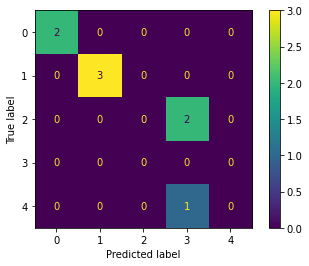

In [17]:
predictions = model.predict(test_x)


matrix = metrics.confusion_matrix(test_y.argmax(axis=1), predictions.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot() 

In [62]:
import sounddevice as sd
from scipy.io.wavfile import write
import time

fs = 44100  # Sample rate
seconds = 3  # Duration of recording
print("Start Speaking Now\n")
time.sleep(0.5)
print('Listening....Speak Now')
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
print("Done Recording\n")

test1 = np.array(myrecording[20000:20000+44100])
test2 = np.array(myrecording[0:44100])



# print(test1.shape)
# print(test2.shape)
# sd.play(test1,fs)
# print("2nd file")
# time.sleep(3)
# print("Wait Done...")
# sd.play(test2,fs)

Start Speaking Now

Listening....Speak Now
Done Recording

(44100, 1)
(44100, 1)
2nd file
Wait Done...
